In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

from pysr import PySRRegressor

from scipy.optimize import curve_fit

In [2]:
from physical_formula_spinvdisk2 import disks_physical_formula_func as phys_eqn

In [3]:
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy import constants as cons


def Delta(z,Om0=0.279,Ob0=0.046,h=0.7):
    #Bryan & Norman 99
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    x=cosmo.Om(z)-1
    return 18*np.pi**2+82*x-39*x**2

def rho_crit(z,Om0=0.279,Ob0=0.046,h=0.7):
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    return cosmo.critical_density(z).to(u.Msun/u.kpc**3).value

def rho_vir(z,Om0=0.279,Ob0=0.046,h=0.7):
    D=Delta(z,Om0=Om0,Ob0=Ob0,h=h)
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    rho_c = cosmo.critical_density(z).to(u.Msun/u.kpc**3).value
    return D*rho_c

def Rvir_to_Mvir(Rvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return rho_v*4./3.*np.pi*Rvir**3   #Msun

def Mvir_to_Rvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return  (Mvir/(rho_v*4./3.*np.pi))**(1./3.)  #kpc

def Mvir_to_Vvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    Rvir = Mvir_to_Rvir(Mvir,z,Om0=Om0,Ob0=Ob0,h=h)
    return (np.sqrt(cons.G*Mvir*u.Msun/(Rvir*u.kpc))).to(u.km/u.s)

In [4]:
df_normalized_31 = pd.read_csv('Halo Mass Normalized Dataset w 31 features.csv')

In [5]:
# df here read from the data filtered file from notebook v5
df_log_mass_filtered_v5 = pd.read_csv ('df_log_mass_filtered_v5.csv') 

In [6]:
df_not_normalized = df_log_mass_filtered_v5.loc[: , :]

In [7]:
df_not_normalized

,GalpropMBH,GalpropMH2,GalpropMHI,GalpropMHII,GalpropMaccdot,GalpropMaccdot_radio,GalpropMbulge,GalpropMcold,GalpropMstar,GalpropMstar_merge,...,GalpropLogMvir,HalopropLogMhot,GalpropLogMbulge,GalpropLogSfr,GalpropLogSfrave100myr,GalpropLogSfrave1gyr,GalpropLogSfrave20myr,Galprop_neutral_H_mass,Galprop_baryon_mass,Galprop_gas_fraction
0,1.301360e+05,0.000000e+00,2.710510e-11,2.283460e+05,0.0,3.504660e-09,7.260470e+07,3.082220e+05,1.050790e+08,1.404410e+06,...,9.653455,9.977905,7.860965,-3.395986,-3.426001,-3.339338,-3.608164,2.710510e-11,1.050790e+08,2.579497e-19
1,5.412750e+05,1.455160e+08,4.310100e+08,2.505300e+08,0.0,4.201900e-08,2.312560e+08,1.111490e+09,2.136860e+09,4.105360e+07,...,11.109008,5.930248,8.364093,-0.994489,-1.012659,-0.833138,-1.206143,5.765260e+08,2.713386e+09,2.124748e-01
2,5.801040e+05,4.618540e+07,3.059520e+08,2.233320e+08,0.0,4.726200e-08,2.406350e+08,7.769080e+08,1.583780e+09,1.306340e+07,...,11.068902,5.747273,8.381359,-1.541164,-1.572371,-1.407537,-1.753413,3.521374e+08,1.935917e+09,1.818969e-01
3,1.366780e+06,6.824820e+07,5.498750e+08,3.847350e+08,0.0,1.404620e-07,3.234520e+08,1.352870e+09,1.241640e+09,5.510730e+07,...,11.231941,6.044273,8.509810,-1.372860,-1.403237,-1.358168,-1.585062,6.181232e+08,1.859763e+09,3.323666e-01
4,1.450610e+06,2.448120e+07,1.699390e+08,1.440650e+08,0.0,9.336400e-08,4.903280e+08,4.571360e+08,1.432650e+09,2.915260e+07,...,10.918804,5.286860,8.690487,-1.821570,-1.854860,-1.798652,-2.033912,1.944202e+08,1.627070e+09,1.194910e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35385,1.102630e+05,7.387440e+06,2.422220e+08,2.593020e+08,0.0,1.361980e-08,7.870290e+06,6.859500e+08,1.312080e+08,1.573820e+06,...,10.715352,4.553191,6.895991,-2.352369,-2.379367,-2.390226,-2.564407,2.496094e+08,3.808174e+08,6.554569e-01
35386,1.803450e+05,4.975330e+06,2.204080e+08,3.347660e+08,0.0,2.598400e-08,1.064620e+07,7.534590e+08,1.234320e+08,1.432870e+06,...,10.736769,8.660254,7.027195,-2.525222,-2.544698,-1.952355,-2.736897,2.253833e+08,3.488153e+08,6.461394e-01
35387,1.402810e+05,7.508750e+07,4.174370e+08,2.042310e+08,0.0,2.262000e-08,2.044020e+07,9.392910e+08,1.227350e+08,8.325890e+06,...,10.713967,8.143789,7.310485,-1.290487,-2.013995,-2.423795,-1.589545,4.925245e+08,6.152595e+08,8.005151e-01
35388,1.603850e+05,3.931530e+07,4.901590e+08,2.665320e+08,0.0,2.295740e-08,1.796060e+07,1.086350e+09,1.518140e+08,1.797880e+06,...,10.734885,7.462965,7.254321,-1.608000,-1.677489,-2.290681,-1.822031,5.294743e+08,6.812883e+08,7.771663e-01


#### Add Vvir to Raw Dataset

In [8]:
# Define Halo property Vvir (as it does not exist in the dataset above)
v= Mvir_to_Vvir (np.array(df_not_normalized.loc[:,'HalopropMvir']),0) # has units

In [9]:
v

<Quantity [21.18004688, 64.73085173, 62.76861958, ..., 47.8003278 ,
           48.5739648 , 48.11187183] km / s>

In [10]:
# add Halo property Vvir
df_not_normalized.loc[:, 'HalopropVvir']=v.value 

In [11]:
df_not_normalized

,GalpropMBH,GalpropMH2,GalpropMHI,GalpropMHII,GalpropMaccdot,GalpropMaccdot_radio,GalpropMbulge,GalpropMcold,GalpropMstar,GalpropMstar_merge,...,HalopropLogMhot,GalpropLogMbulge,GalpropLogSfr,GalpropLogSfrave100myr,GalpropLogSfrave1gyr,GalpropLogSfrave20myr,Galprop_neutral_H_mass,Galprop_baryon_mass,Galprop_gas_fraction,HalopropVvir
0,1.301360e+05,0.000000e+00,2.710510e-11,2.283460e+05,0.0,3.504660e-09,7.260470e+07,3.082220e+05,1.050790e+08,1.404410e+06,...,9.977905,7.860965,-3.395986,-3.426001,-3.339338,-3.608164,2.710510e-11,1.050790e+08,2.579497e-19,21.180047
1,5.412750e+05,1.455160e+08,4.310100e+08,2.505300e+08,0.0,4.201900e-08,2.312560e+08,1.111490e+09,2.136860e+09,4.105360e+07,...,5.930248,8.364093,-0.994489,-1.012659,-0.833138,-1.206143,5.765260e+08,2.713386e+09,2.124748e-01,64.730852
2,5.801040e+05,4.618540e+07,3.059520e+08,2.233320e+08,0.0,4.726200e-08,2.406350e+08,7.769080e+08,1.583780e+09,1.306340e+07,...,5.747273,8.381359,-1.541164,-1.572371,-1.407537,-1.753413,3.521374e+08,1.935917e+09,1.818969e-01,62.768620
3,1.366780e+06,6.824820e+07,5.498750e+08,3.847350e+08,0.0,1.404620e-07,3.234520e+08,1.352870e+09,1.241640e+09,5.510730e+07,...,6.044273,8.509810,-1.372860,-1.403237,-1.358168,-1.585062,6.181232e+08,1.859763e+09,3.323666e-01,71.135923
4,1.450610e+06,2.448120e+07,1.699390e+08,1.440650e+08,0.0,9.336400e-08,4.903280e+08,4.571360e+08,1.432650e+09,2.915260e+07,...,5.286860,8.690487,-1.821570,-1.854860,-1.798652,-2.033912,1.944202e+08,1.627070e+09,1.194910e-01,55.938390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35385,1.102630e+05,7.387440e+06,2.422220e+08,2.593020e+08,0.0,1.361980e-08,7.870290e+06,6.859500e+08,1.312080e+08,1.573820e+06,...,4.553191,6.895991,-2.352369,-2.379367,-2.390226,-2.564407,2.496094e+08,3.808174e+08,6.554569e-01,47.851193
35386,1.803450e+05,4.975330e+06,2.204080e+08,3.347660e+08,0.0,2.598400e-08,1.064620e+07,7.534590e+08,1.234320e+08,1.432870e+06,...,8.660254,7.027195,-2.525222,-2.544698,-1.952355,-2.736897,2.253833e+08,3.488153e+08,6.461394e-01,48.644280
35387,1.402810e+05,7.508750e+07,4.174370e+08,2.042310e+08,0.0,2.262000e-08,2.044020e+07,9.392910e+08,1.227350e+08,8.325890e+06,...,8.143789,7.310485,-1.290487,-2.013995,-2.423795,-1.589545,4.925245e+08,6.152595e+08,8.005151e-01,47.800328
35388,1.603850e+05,3.931530e+07,4.901590e+08,2.665320e+08,0.0,2.295740e-08,1.796060e+07,1.086350e+09,1.518140e+08,1.797880e+06,...,7.462965,7.254321,-1.608000,-1.677489,-2.290681,-1.822031,5.294743e+08,6.812883e+08,7.771663e-01,48.573965


#### Add BulgeMstar_ratio to the normalized and the raw datasets to compare with each other (check consistency)

In [12]:
df_not_normalized.loc[:, 'BulgeMstar_ratio'] = df_not_normalized.loc[:,'GalpropMbulge']/df_not_normalized.loc[:, 'GalpropMstar']

In [13]:
df_normalized_31.loc[:, 'BulgeMstar_ratio'] = df_normalized_31.loc[:,'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar']

In [14]:
df_not_normalized.loc[:, 'GalpropMdisk'] = df_not_normalized.loc[:, 'GalpropMstar'] - df_not_normalized.loc[:, 'GalpropMbulge']

In [15]:
df_normalized_31.loc[:, 'GalpropNormMdisk'] = df_normalized_31.loc[:, 'GalpropNormMstar'] - df_normalized_31.loc[:, 'GalpropNormMbulge']

In [16]:
df_not_normalized.loc[:, 'DiskMstar_ratio']  = df_not_normalized.loc[:, 'GalpropMdisk']/df_not_normalized.loc[:, 'GalpropMstar']

In [17]:
df_normalized_31.loc[:, 'DiskMstar_ratio']  = df_normalized_31.loc[:, 'GalpropNormMdisk']/df_normalized_31.loc[:, 'GalpropNormMstar']

In [18]:
df_not_normalized.shape

(35390, 70)

In [19]:
df_normalized_31.shape

(35390, 35)

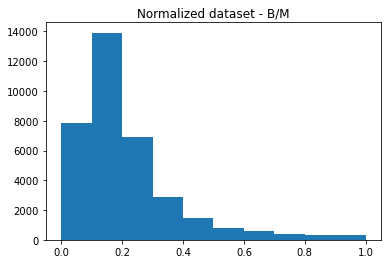

In [20]:
plt.hist(df_normalized_31['BulgeMstar_ratio'])
plt.title('Normalized dataset - B/M')
plt.show()

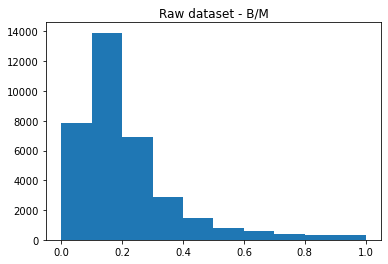

In [21]:
plt.hist(df_not_normalized['BulgeMstar_ratio'])
plt.title('Raw dataset - B/M')
plt.show()

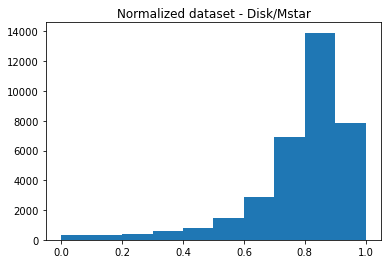

In [22]:
plt.hist(df_normalized_31['DiskMstar_ratio'])
plt.title('Normalized dataset - Disk/Mstar')
plt.show()

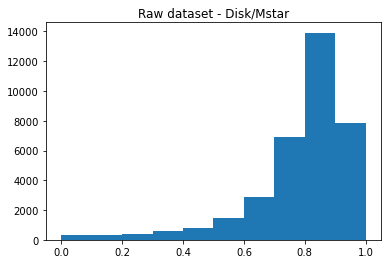

In [23]:
plt.hist(df_not_normalized['DiskMstar_ratio'])
plt.title('Raw dataset - Disk/Mstar')
plt.show()

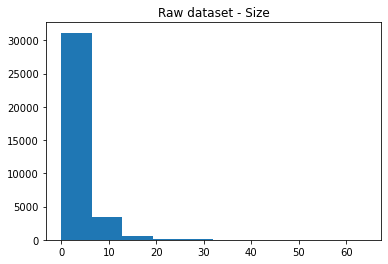

In [24]:
plt.hist(df_not_normalized['GalpropHalfRadius'])
plt.title('Raw dataset - Size')
plt.show()

#### Define the 6 morphology groups by increasing Mbulge/Mstar ratio

In [25]:
# 7,865 galaxies in df_1
df_1 = df_normalized_31.loc[df_normalized_31.loc[:, 'BulgeMstar_ratio']<=0.10] 
df_1_raw = df_not_normalized.loc[df_not_normalized.loc[:, 'BulgeMstar_ratio']<=0.10] 


# 13,921 galaxies in df_2
df_2 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.10) & (df_normalized_31.BulgeMstar_ratio <= 0.20)] 
df_2_raw = df_not_normalized.loc[(df_not_normalized.BulgeMstar_ratio > 0.10) & (df_not_normalized.BulgeMstar_ratio <= 0.20)] 


# 6,880 galaxies in df_3
df_3 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.20) & (df_normalized_31.BulgeMstar_ratio <= 0.30)] 
df_3_raw = df_not_normalized.loc[(df_not_normalized.BulgeMstar_ratio > 0.20) & (df_not_normalized.BulgeMstar_ratio <= 0.30)] 


# 2,858 galaxies in df_4
df_4 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.30) & (df_normalized_31.BulgeMstar_ratio <= 0.40)] 
df_4_raw = df_not_normalized.loc[(df_not_normalized.BulgeMstar_ratio > 0.30) & (df_not_normalized.BulgeMstar_ratio <= 0.40)] 


# 1,444 galaxies in df_5
df_5 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.40) & (df_normalized_31.BulgeMstar_ratio <= 0.50)] 
df_5_raw = df_not_normalized.loc[(df_not_normalized.BulgeMstar_ratio > 0.40) & (df_not_normalized.BulgeMstar_ratio <= 0.50)] 


# 2,422 galaxies in df_5
df_6 = df_normalized_31.loc[df_normalized_31.loc[:, 'BulgeMstar_ratio']>0.50] 
df_6_raw = df_not_normalized.loc[df_not_normalized.loc[:, 'BulgeMstar_ratio']>0.50] 

# Combined morphologies 1 to 4 in order to fit one physical model to all of them; 31,524 galaxies in the 1-4 morphologies
df_14 = df_normalized_31.loc[df_normalized_31.BulgeMstar_ratio <= 0.40] #normalized
df_14_raw = df_not_normalized.loc[df_not_normalized.BulgeMstar_ratio <= 0.40] 





In [26]:
df_14.shape

(31524, 35)

In [27]:
df_14_raw.shape # 31,524 (out of 35,390) galaxies, that is 90% of the dataset, are in groups 1-4

(31524, 70)

#### equation for df_6 = ellipticals is different from the rest

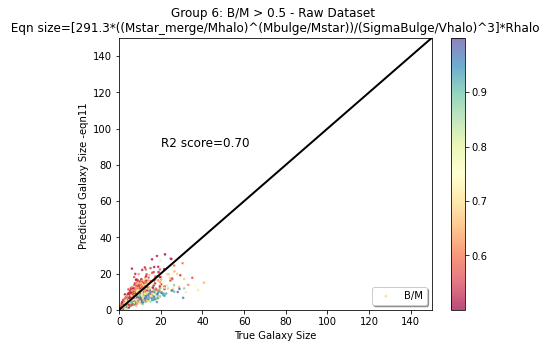

In [28]:
eqn11 = (291.3*np.abs(df_6_raw.loc[:,'GalpropMstar_merge']/df_6_raw.loc[:,'HalopropMvir'])**df_6_raw.loc[:,'BulgeMstar_ratio']/(df_6_raw.loc[:,'GalpropSigmaBulge']/df_6_raw.loc[:,'HalopropVvir'])**3)*df_6_raw.loc[:,'GalpropRhalo']


r2_score_11=r2_score(df_6_raw.loc[:, 'GalpropHalfRadius'], eqn11)

fig_complete, ax = plt.subplots(figsize=(7, 5))
    
ax = plt.subplot()

fig_6 = ax.scatter(df_6_raw.loc[:, 'GalpropHalfRadius'], eqn11,
            c = df_6_raw.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7,label= 'B/M') #, vmin=-2, vmax=1.0)
ax.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_11), size=12)
ax.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax.set_xlim([0.0,150])
ax.set_ylim([0.0,150])
ax.set_title('Group 6: B/M > 0.5 - Raw Dataset \n Eqn size=[291.3*((Mstar_merge/Mhalo)^(Mbulge/Mstar))/(SigmaBulge/Vhalo)^3]*Rhalo ')
ax.set_xlabel('True Galaxy Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size -eqn11 ')
fig_complete.colorbar(fig_6, ax=ax)
# plt.savefig('Rawdataset_Ellipticals_SR_eqn6_vs_true_gal_size.jpeg', dpi=500)
plt.show()

## Function size3(Mdisk/Mstar,spin,vdisk) = a*spin/vdisk^2 + c*Mdisk/Mstar*spin/vdisk^2

In [29]:
def mdiskmstar_spin_vdisk2_func(spin_vdisk_diskmstar_halo, c, spin_min):
    # spin_vdisk is a 2,M array that contains HalopropSpin and GalpropNormVdisk
    # spin is sspin_vdisk_diskmstar_halo[0]
    # vdisk is spin_vdisk_diskmstar_halo[1]
    # Mdisk/Mstar is spin_vdisk_diskmstar_halo[2]
    # halomass is spin_vdisk_diskmstar_halo[3]
    # halorad (size of halo) is spin_vdisk_diskmstar_halo[4]
#     spin_min = 0.02
    spin_use = np.copy(spin_vdisk_diskmstar_halo[0])
    vdisk = np.copy(spin_vdisk_diskmstar_halo[1])
    diskmstar = np.copy (spin_vdisk_diskmstar_halo[2])
    halovelocity = np.copy(spin_vdisk_diskmstar_halo[3])
    halorad = np.copy(spin_vdisk_diskmstar_halo[4])


    spin_use[spin_use < spin_min] = spin_min
    
    size = (c*diskmstar*spin_use/(vdisk/halovelocity)**2) * halorad * 1000 # the 1000 factor is there to account for unit differences between Mpc and kpc

    return size

In [30]:
def disks_physical_formula_func_version3 (df, group):
    
    """ This function takes a df as an input, then: a) extracts the size, spin and vdisk columns from the df, 
    b) forms a 2,M array with the spin & vdisk columns (called spin_vdisk)
    c) uses curve_fit to find the optimal parameters of spin_vdisk2_func (whose input is spin_vdisk and true size of the galaxies from the df)
    d) calculates the R2 score of true size vs predicted size by the spin_vdisk2_func on the complete dataset, df
    e) calculates the R2 score of true size vs predicted size by the spin_vdisk2_func on on the galaxies with low spin (spin<0.021)
    f) Plots the figure of the true size vs predicted size for each group of galaxy morphology (noted in the title)
    
    It returns: the spin_vdisk 2,M array, the optimal parameters and pcov from curve_fit, the size array obtained
    by applying spin_vdisk2_func on spin_vdisk with parameters obtained from curve_fit, and the
    figure comparing true size vs predicted size
    
    Note: the group input has to be in a string format"""
    
#   a)
    halovelocity=np.array(df.loc[:,'HalopropVvir'])
    halorad= np.array(df.loc[:,'GalpropRhalo'])
    
    Size_true = np.array(df.loc[:, 'GalpropHalfRadius']) 
    HalopropSpin = np.array(df.loc[:, 'HalopropSpin'])
    GalpropVdisk = np.array(df.loc[:, 'GalpropVdisk'])
#   b) 
    spin_vdisk = [HalopropSpin, GalpropVdisk]
    spin_vdisk = np.array (spin_vdisk) # convert list into array
    
    BulgeMstar = np.array (df.loc[:, 'BulgeMstar_ratio'])
    
    Mdisk = np.array (df.loc[:, 'GalpropMdisk'])
    
    DiskMstar = np.array (df.loc[:, 'DiskMstar_ratio'])
    
    spin_vdisk_diskmstar_halo = np. array([HalopropSpin, GalpropVdisk, DiskMstar, halovelocity, halorad])
    
#     spin_vdisk_diskmstar = np. array([HalopropSpin, GalpropVdisk, DiskMstar])

#     spin_vdisk_bmstar = np. array([HalopropSpin, GalpropNormVdisk, BulgeMstar])


#   c)
# use first line when spin_min is variable
    popt, pcov = curve_fit(mdiskmstar_spin_vdisk2_func, spin_vdisk_diskmstar_halo, Size_true, p0=[160, 0.021])
# use second line when spin_min is fixed   
#     popt, pcov = curve_fit(mdiskmstar_spin_vdisk2_func, spin_vdisk_diskmstar, Size_true, p0=[1000, 500])


    size_func = mdiskmstar_spin_vdisk2_func(spin_vdisk_diskmstar_halo, *popt)
#   d) 
    r2_score_df = r2_score(Size_true, size_func)
    r2_score_df
#   e) 
    df_spin_size = df.loc[:,['GalpropHalfRadius', 'HalopropSpin']]
    df_spin_size.loc[:, "Predicted"] = size_func
    zz = df_spin_size[df_spin_size.loc[:,'HalopropSpin']<=0.021]
    actual_size= zz['GalpropHalfRadius']
    predicted_size = zz['Predicted']
    r2_score_lowspin = r2_score(actual_size, predicted_size)

#   f) Plot the figure
    fig_prediction, ax = plt.subplots(figsize=(7, 5))
    
    ax = plt.subplot()
    im = ax.scatter(Size_true, size_func, marker='.', s=10, alpha=0.7, 
#                 c  = df.loc[:,'GalpropMdisk'],
                c  = df.loc[:,'BulgeMstar_ratio'],  
                cmap='Spectral',
#                 label=' colorbar: Mdisk/Mstar ratio \n fit: a=%5.3f \n c=%5.3f' % tuple(popt))
                label=' colorbar: Mdisk/Mstar ratio \n fit: c=%5.3f \n spin_min=%5.3f' % tuple(popt))
    ax.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
    ax.set_xlim([0.0,25])
    ax.set_ylim([0.0,25])
    ax.text(0.5, 23, 'R2 score=' + '{:.2f}'.format(r2_score_df), size=12)
    ax.text(0.5, 22, 'R2_lowspin_gals=' + '{:.2f}'.format(r2_score(actual_size, predicted_size)), size=12)
    ax.set_title('{} - Raw Dataset \n Eqn size= a*spin/vdisk^2 + c*Mdisk/Mstar*spin/vdisk^2 vs True Size '.format(group))
    ax.set_ylabel('Size as predicted by spin/vdisk^2 function [kpc]')
    ax.set_xlabel('True Size [kpc]')
    ax.legend(loc = 'lower right', shadow=True)
    fig_prediction.colorbar(im, ax=ax)
    
    fig_prediction.tight_layout()
    # plt.savefig('BulgierDisks_TrueSize_vs_FunctionSize_15_wsmallgals.jpeg', dpi=500)
    plt.show()
    
    return spin_vdisk_diskmstar_halo, popt, pcov, size_func, fig_prediction, r2_score_df, r2_score_lowspin

## Physical Model Optimized on combined dataset, Groups 1-4

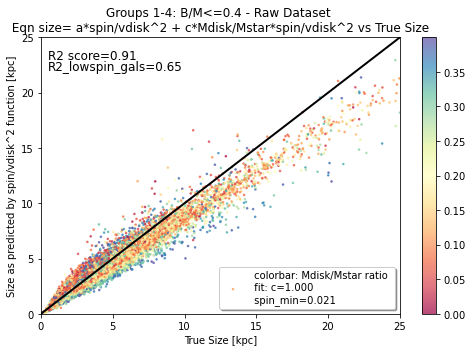

In [33]:
results_df_14 = disks_physical_formula_func_version4(df_14_raw, group = 'Groups 1-4: B/M<=0.4')
popt14 = results_df_14[1]

In [34]:
print (popt14)

[1.0, 0.021]


In [35]:
def disks_physical_formula_func_version4 (df, group):
    
    """ This function takes a df as an input, then: a) extracts the size, spin and vdisk columns from the df, 
    b) forms a 2,M array with the spin & vdisk columns (called spin_vdisk)
    c) does not use curve_fit but only applies given function #uses curve_fit to find the optimal parameters of spin_vdisk2_func (whose input is spin_vdisk and true size of the galaxies from the df)
    d) calculates the R2 score of true size vs predicted size by the spin_vdisk2_func on the complete dataset, df
    e) calculates the R2 score of true size vs predicted size by the spin_vdisk2_func on on the galaxies with low spin (spin<0.021)
    f) Plots the figure of the true size vs predicted size for each group of galaxy morphology (noted in the title)
    
    It returns: the spin_vdisk 2,M array, the optimal parameters and pcov from curve_fit, the size array obtained
    by applying spin_vdisk2_func on spin_vdisk with parameters obtained from curve_fit, and the
    figure comparing true size vs predicted size
    
    Note: the group input has to be in a string format"""
    
#   a)
    halovelocity=np.array(df.loc[:,'HalopropVvir'])
    halorad= np.array(df.loc[:,'GalpropRhalo'])
    
    Size_true = np.array(df.loc[:, 'GalpropHalfRadius']) 
    HalopropSpin = np.array(df.loc[:, 'HalopropSpin'])
    GalpropVdisk = np.array(df.loc[:, 'GalpropVdisk'])
#   b) 
    spin_vdisk = [HalopropSpin, GalpropVdisk]
    spin_vdisk = np.array (spin_vdisk) # convert list into array
    
    BulgeMstar = np.array (df.loc[:, 'BulgeMstar_ratio'])
    
    Mdisk = np.array (df.loc[:, 'GalpropMdisk'])
    
    DiskMstar = np.array (df.loc[:, 'DiskMstar_ratio'])
    
    spin_vdisk_diskmstar_halo = np. array([HalopropSpin, GalpropVdisk, DiskMstar, halovelocity, halorad])
    
#     spin_vdisk_diskmstar = np. array([HalopropSpin, GalpropVdisk, DiskMstar])

#     spin_vdisk_bmstar = np. array([HalopropSpin, GalpropNormVdisk, BulgeMstar])


#   c)
# use first line when spin_min is variable
#     popt, pcov = curve_fit(mdiskmstar_spin_vdisk2_func, spin_vdisk_diskmstar_halo, Size_true, p0=[10, 500, 0.021])
# use second line when spin_min is fixed   
#     popt, pcov = curve_fit(mdiskmstar_spin_vdisk2_func, spin_vdisk_diskmstar, Size_true, p0=[1000, 500])

# popt now from popt14 = [-0.03466038  1.1864195   0.01997989], rounded to 2 digits
    popt = [1.0, 0.021]
    size_func = mdiskmstar_spin_vdisk2_func(spin_vdisk_diskmstar_halo, *popt)
#   d) 
    r2_score_df = r2_score(Size_true, size_func)
    r2_score_df
#   e) 
    df_spin_size = df.loc[:,['GalpropHalfRadius', 'HalopropSpin']]
    df_spin_size.loc[:, "Predicted"] = size_func
    zz = df_spin_size[df_spin_size.loc[:,'HalopropSpin']<=0.021]
    actual_size= zz['GalpropHalfRadius']
    predicted_size = zz['Predicted']
    r2_score_lowspin = r2_score(actual_size, predicted_size)

#   f) Plot the figure
    fig_prediction, ax = plt.subplots(figsize=(7, 5))
    
    ax = plt.subplot()
    im = ax.scatter(Size_true, size_func, marker='.', s=10, alpha=0.7, 
#                 c  = df.loc[:,'GalpropMdisk'],
                c  = df.loc[:,'BulgeMstar_ratio'],  
                cmap='Spectral',
#                 label=' colorbar: Mdisk/Mstar ratio \n fit: a=%5.3f \n c=%5.3f' % tuple(popt))
                label=' colorbar: Mdisk/Mstar ratio \n fit: c=%5.3f \n spin_min=%5.3f' % tuple(popt))
    ax.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
    ax.set_xlim([0.0,25])
    ax.set_ylim([0.0,25])
    ax.text(0.5, 23, 'R2 score=' + '{:.2f}'.format(r2_score_df), size=12)
    ax.text(0.5, 22, 'R2_lowspin_gals=' + '{:.2f}'.format(r2_score(actual_size, predicted_size)), size=12)
    ax.set_title('{} - Raw Dataset \n Eqn size= c*Mdisk/Mstar*spin/vdisk^2 vs True Size '.format(group))
    ax.set_ylabel('Size as predicted by spin/vdisk^2 function [kpc]')
    ax.set_xlabel('True Size [kpc]')
    ax.legend(loc = 'lower right', shadow=True)
    fig_prediction.colorbar(im, ax=ax)
    
    fig_prediction.tight_layout()
    # plt.savefig('BulgierDisks_TrueSize_vs_FunctionSize_15_wsmallgals.jpeg', dpi=500)
    plt.show()
    
    return spin_vdisk_diskmstar_halo, popt, popt, size_func, fig_prediction, r2_score_df, r2_score_lowspin

#### results for optimizing a and c on combined Groups 1-4 and using those values in the function for each
morphology bin
The unexcpected difference is observed on Group 1 where R2 score goes from 0.96 to 0.94, while a goes from 0.9 to 0.035 and c from 0.161 to 1.186. In this group then the galaxies become overpredicted.

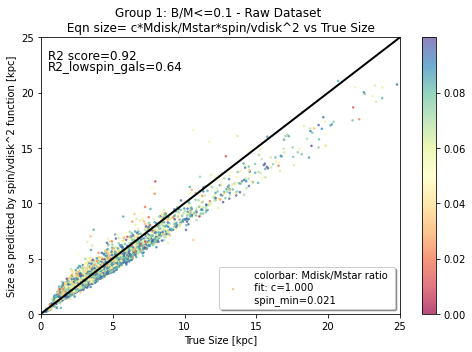

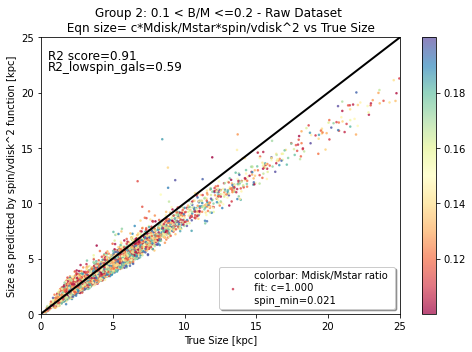

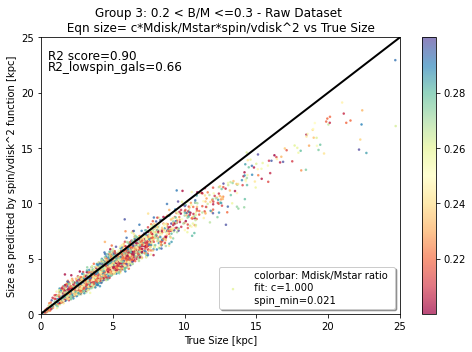

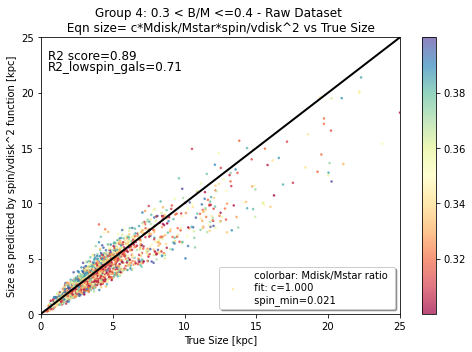

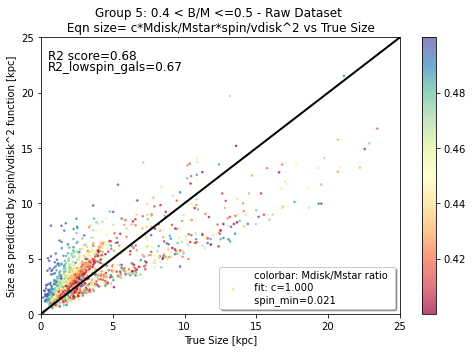

In [36]:
results_df_1 = disks_physical_formula_func_version4(df_1_raw, group = 'Group 1: B/M<=0.1')
popt1 = results_df_1[1]

results_df_2 = disks_physical_formula_func_version4(df_2_raw, group = 'Group 2: 0.1 < B/M <=0.2')
popt2 = results_df_2[1]

results_df_3 = disks_physical_formula_func_version4(df_3_raw, group = 'Group 3: 0.2 < B/M <=0.3')
popt3 = results_df_3[1]

results_df_4 = disks_physical_formula_func_version4(df_4_raw, group = 'Group 4: 0.3 < B/M <=0.4')
popt4 = results_df_4[1]

results_df_5 = disks_physical_formula_func_version4(df_5_raw, group = 'Group 5: 0.4 < B/M <=0.5')
popt5 = results_df_5[1]

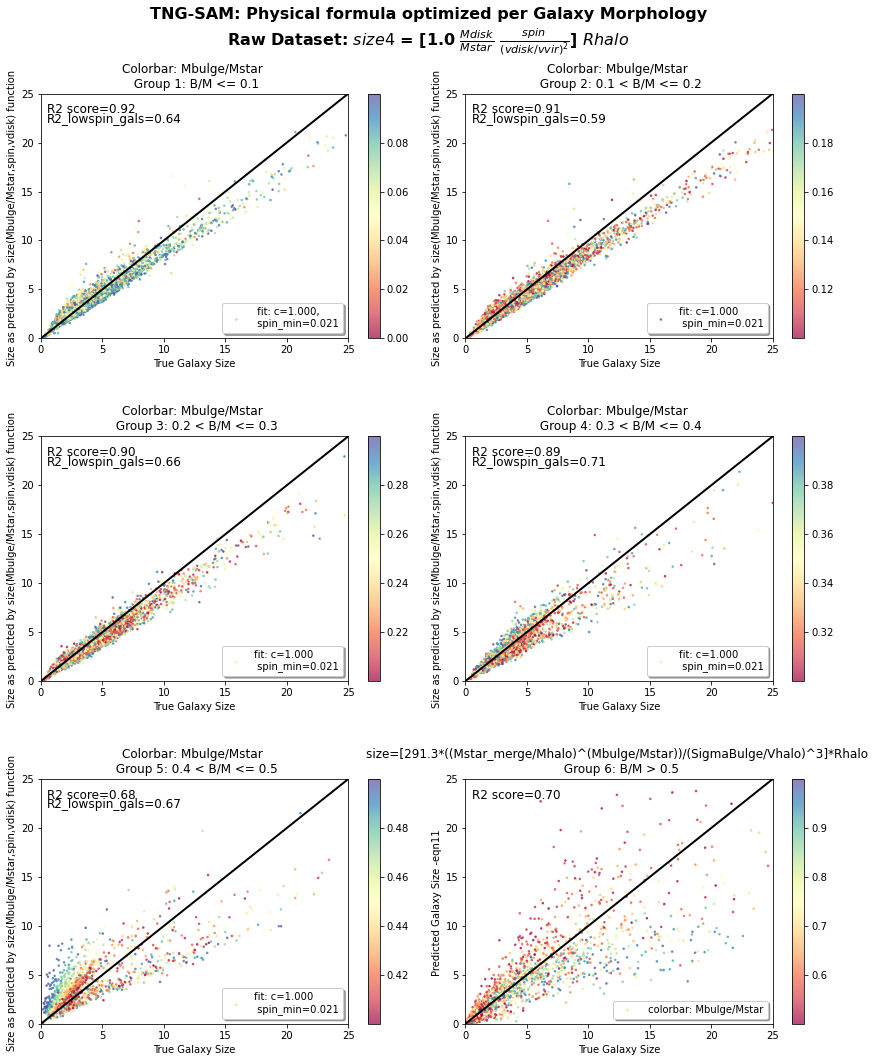

In [37]:
import matplotlib.cm as cm
import matplotlib.colors as norm
# from OpenCV import cv2 as cv #package OpenCV not installed

fig_all,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(12,15))
fig_all.suptitle('TNG-SAM: Physical formula optimized per Galaxy Morphology' + "\n" + 
#                  r'Raw Dataset: $size3$ = [0.8 $\frac{spin}{(vdisk/vvir)^{2}}$ + 0.186 $\frac{Mdisk}{Mstar}$ $\frac{spin}{(vdisk/vvir)^{2}}$] $Rhalo$', fontsize=16, fontweight='bold')
                 r'Raw Dataset: $size4$ = [1.0 $\frac{Mdisk}{Mstar}$ $\frac{spin}{(vdisk/vvir)^{2}}$] $Rhalo$', fontsize=16, fontweight='bold')


fig_1 = ax1.scatter(df_1_raw.loc[:, 'GalpropHalfRadius'], results_df_1[3],
            c = df_1_raw.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label=' fit: c=%5.3f, \n spin_min=%5.3f' % tuple(popt1)) #,label= label, vmin=-2, vmax=1.0)
ax1.text(0.5, 23, 'R2 score=' + '{:.2f}'.format(results_df_1[5]), size=12)
ax1.text(0.5, 22, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_1[6]), size=12)
ax1.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax1.set_xlim([0.0,25])
ax1.set_ylim([0.0,25])
ax1.set_title('Colorbar: Mbulge/Mstar \n Group 1: B/M <= 0.1')
ax1.set_xlabel('True Galaxy Size')
ax1.legend(loc = 'lower right', shadow=True)
ax1.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_1, ax=ax1)

fig_2 = ax2.scatter(df_2_raw.loc[:, 'GalpropHalfRadius'], results_df_2[3],
            c = df_2_raw.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit: c=%5.3f \n spin_min=%5.3f' % tuple(popt2)) #,label= label, vmin=-2, vmax=1.0)
ax2.text(0.5, 23, 'R2 score=' + '{:.2f}'.format(results_df_2[5]), size=12)
ax2.text(0.5, 22, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_2[6]), size=12)
ax2.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax2.set_xlim([0.0,25])
ax2.set_ylim([0.0,25])
ax2.set_title('Colorbar: Mbulge/Mstar \n Group 2: 0.1 < B/M <= 0.2')
ax2.set_xlabel('True Galaxy Size')
ax2.legend(loc = 'lower right', shadow=True)
ax2.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_2, ax=ax2)

fig_3 = ax3.scatter(df_3_raw.loc[:, 'GalpropHalfRadius'], results_df_3[3],
            c = df_3_raw.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit: c=%5.3f \n spin_min=%5.3f' % tuple(popt3)) #,label= label, vmin=-2, vmax=1.0)
ax3.text(0.5, 23, 'R2 score=' + '{:.2f}'.format(results_df_3[5]), size=12)
ax3.text(0.5, 22, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_3[6]), size=12)
ax3.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax3.set_xlim([0.0,25])
ax3.set_ylim([0.0,25])
ax3.set_title('Colorbar: Mbulge/Mstar \n Group 3: 0.2 < B/M <= 0.3')
ax3.set_xlabel('True Galaxy Size')
ax3.legend(loc = 'lower right', shadow=True)
ax3.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_3, ax=ax3)

fig_4 = ax4.scatter(df_4_raw.loc[:, 'GalpropHalfRadius'], results_df_4[3],
            c = df_4_raw.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit: c=%5.3f \n spin_min=%5.3f' % tuple(popt4)) #,label= label, vmin=-2, vmax=1.0)
ax4.text(0.5, 23, 'R2 score=' + '{:.2f}'.format(results_df_4[5]), size=12)
ax4.text(0.5, 22, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_4[6]), size=12)
ax4.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax4.set_xlim([0.0,25])
ax4.set_ylim([0.0,25])
ax4.set_title('Colorbar: Mbulge/Mstar \n Group 4: 0.3 < B/M <= 0.4')
ax4.set_xlabel('True Galaxy Size')
ax4.legend(loc = 'lower right', shadow=True)
ax4.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_4, ax=ax4)

fig_5 = ax5.scatter(df_5_raw.loc[:, 'GalpropHalfRadius'], results_df_5[3],
            c = df_5_raw.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit: c=%5.3f \n spin_min=%5.3f' % tuple(popt5)) #,label= label, vmin=-2, vmax=1.0)
ax5.text(0.5, 23, 'R2 score=' + '{:.2f}'.format(results_df_5[5]), size=12)
ax5.text(0.5, 22, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_5[6]), size=12)
ax5.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax5.set_xlim([0.0,25])
ax5.set_ylim([0.0,25])
ax5.set_title('Colorbar: Mbulge/Mstar \n Group 5: 0.4 < B/M <= 0.5')
ax5.set_xlabel('True Galaxy Size')
ax5.legend(loc = 'lower right', shadow=True)
ax5.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_5, ax=ax5)


fig_6 = ax6.scatter(df_6_raw.loc[:, 'GalpropHalfRadius'], eqn11,
            c = df_6_raw.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label=' colorbar: Mbulge/Mstar') #,label= label, vmin=-2, vmax=1.0)
ax6.text(0.5, 23, 'R2 score=' + '{:.2f}'.format(r2_score_11), size=12)
ax6.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax6.set_xlim([0.0,25])
ax6.set_ylim([0.0,25])
ax6.set_title('size=[291.3*((Mstar_merge/Mhalo)^(Mbulge/Mstar))/(SigmaBulge/Vhalo)^3]*Rhalo \n Group 6: B/M > 0.5')
ax6.set_xlabel('True Galaxy Size')
ax6.legend(loc = 'lower right', shadow=True)
ax6.set_ylabel('Predicted Galaxy Size -eqn11 ')
fig_all.colorbar(fig_6, ax=ax6)

# def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
#     "Sign sets of subplots with title"
#     row = fig.add_subplot(grid)
#     # the '\n' is important
#     row.set_title(f'{title}\n', fontweight='semibold')
#     # hide subplot
#     row.set_frame_on(False)
#     row.axis('off')
    
# grid2 = plt.GridSpec(2, 2)
# create_subtitle(fig2, grid2[0, ::], 'mHI')
# create_subtitle(fig2, grid2[1, ::], 'mH2')
fig_all.tight_layout()
fig_all.subplots_adjust(top=0.90, hspace=0.4) #, wspace=0.4)

# plt.savefig("TNG-SAM_physform_wdimensions_size4_factor_c1_halorad_in_kpc_units.jpeg", dpi=500)
plt.show()

## Physical Model Optimized per each Galaxy Morphology bin

##### results from optimizing a and c in each morphology bin

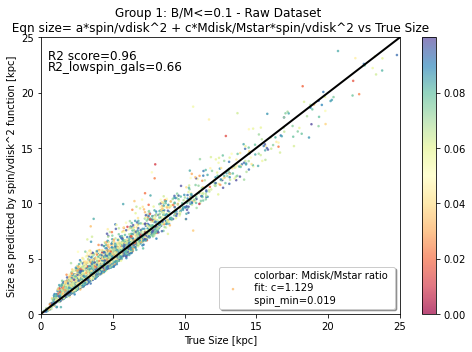

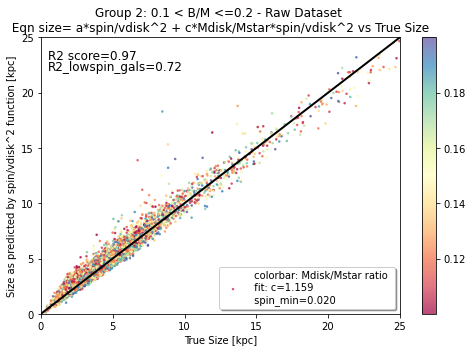

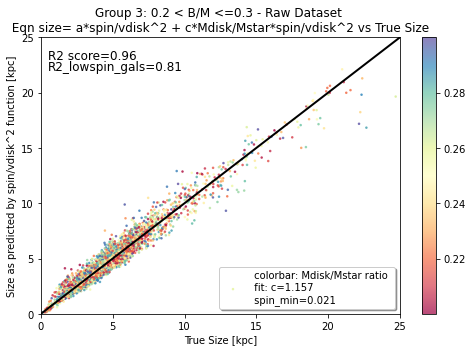

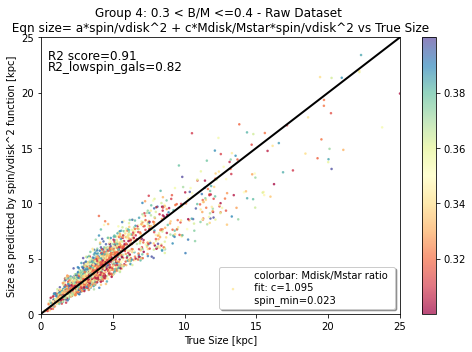

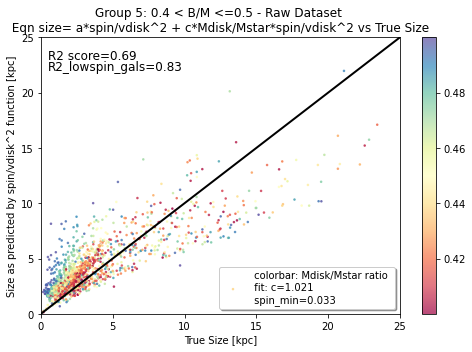

In [33]:
results_df_1 = disks_physical_formula_func_version3(df_1_raw, group = 'Group 1: B/M<=0.1')
popt1 = results_df_1[1]

results_df_2 = disks_physical_formula_func_version3(df_2_raw, group = 'Group 2: 0.1 < B/M <=0.2')
popt2 = results_df_2[1]

results_df_3 = disks_physical_formula_func_version3(df_3_raw, group = 'Group 3: 0.2 < B/M <=0.3')
popt3 = results_df_3[1]

results_df_4 = disks_physical_formula_func_version3(df_4_raw, group = 'Group 4: 0.3 < B/M <=0.4')
popt4 = results_df_4[1]

results_df_5 = disks_physical_formula_func_version3(df_5_raw, group = 'Group 5: 0.4 < B/M <=0.5')
popt5 = results_df_5[1]

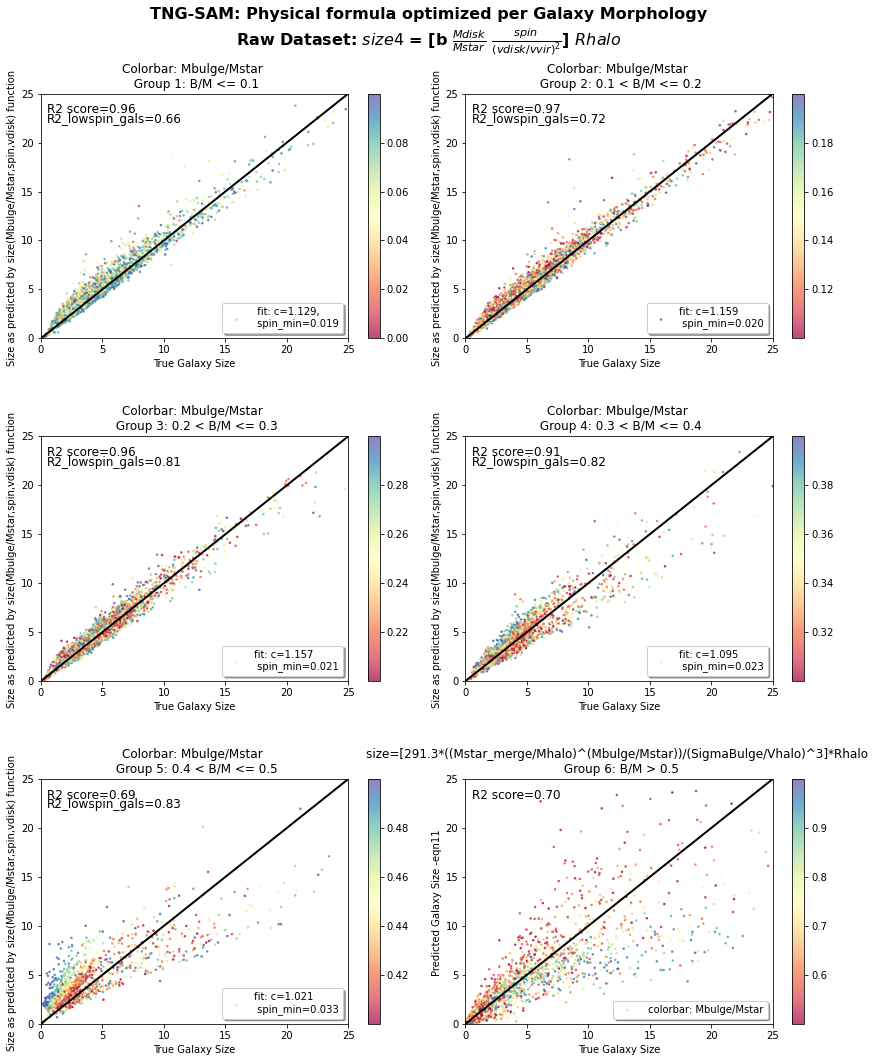

In [36]:
import matplotlib.cm as cm
import matplotlib.colors as norm
# from OpenCV import cv2 as cv #package OpenCV not installed

fig_all,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(12,15))
fig_all.suptitle('TNG-SAM: Physical formula optimized per Galaxy Morphology' + "\n" + 
#                  r'Raw Dataset: $size3$ = [0.8 $\frac{spin}{(vdisk/vvir)^{2}}$ + 0.186 $\frac{Mdisk}{Mstar}$ $\frac{spin}{(vdisk/vvir)^{2}}$] $Rhalo$', fontsize=16, fontweight='bold')
                 r'Raw Dataset: $size4$ = [b $\frac{Mdisk}{Mstar}$ $\frac{spin}{(vdisk/vvir)^{2}}$] $Rhalo$', fontsize=16, fontweight='bold')


fig_1 = ax1.scatter(df_1_raw.loc[:, 'GalpropHalfRadius'], results_df_1[3],
            c = df_1_raw.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label=' fit: c=%5.3f, \n spin_min=%5.3f' % tuple(popt1)) #,label= label, vmin=-2, vmax=1.0)
ax1.text(0.5, 23, 'R2 score=' + '{:.2f}'.format(results_df_1[5]), size=12)
ax1.text(0.5, 22, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_1[6]), size=12)
ax1.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax1.set_xlim([0.0,25])
ax1.set_ylim([0.0,25])
ax1.set_title('Colorbar: Mbulge/Mstar \n Group 1: B/M <= 0.1')
ax1.set_xlabel('True Galaxy Size')
ax1.legend(loc = 'lower right', shadow=True)
ax1.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_1, ax=ax1)

fig_2 = ax2.scatter(df_2_raw.loc[:, 'GalpropHalfRadius'], results_df_2[3],
            c = df_2_raw.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit: c=%5.3f \n spin_min=%5.3f' % tuple(popt2)) #,label= label, vmin=-2, vmax=1.0)
ax2.text(0.5, 23, 'R2 score=' + '{:.2f}'.format(results_df_2[5]), size=12)
ax2.text(0.5, 22, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_2[6]), size=12)
ax2.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax2.set_xlim([0.0,25])
ax2.set_ylim([0.0,25])
ax2.set_title('Colorbar: Mbulge/Mstar \n Group 2: 0.1 < B/M <= 0.2')
ax2.set_xlabel('True Galaxy Size')
ax2.legend(loc = 'lower right', shadow=True)
ax2.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_2, ax=ax2)

fig_3 = ax3.scatter(df_3_raw.loc[:, 'GalpropHalfRadius'], results_df_3[3],
            c = df_3_raw.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit: c=%5.3f \n spin_min=%5.3f' % tuple(popt3)) #,label= label, vmin=-2, vmax=1.0)
ax3.text(0.5, 23, 'R2 score=' + '{:.2f}'.format(results_df_3[5]), size=12)
ax3.text(0.5, 22, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_3[6]), size=12)
ax3.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax3.set_xlim([0.0,25])
ax3.set_ylim([0.0,25])
ax3.set_title('Colorbar: Mbulge/Mstar \n Group 3: 0.2 < B/M <= 0.3')
ax3.set_xlabel('True Galaxy Size')
ax3.legend(loc = 'lower right', shadow=True)
ax3.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_3, ax=ax3)

fig_4 = ax4.scatter(df_4_raw.loc[:, 'GalpropHalfRadius'], results_df_4[3],
            c = df_4_raw.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit: c=%5.3f \n spin_min=%5.3f' % tuple(popt4)) #,label= label, vmin=-2, vmax=1.0)
ax4.text(0.5, 23, 'R2 score=' + '{:.2f}'.format(results_df_4[5]), size=12)
ax4.text(0.5, 22, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_4[6]), size=12)
ax4.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax4.set_xlim([0.0,25])
ax4.set_ylim([0.0,25])
ax4.set_title('Colorbar: Mbulge/Mstar \n Group 4: 0.3 < B/M <= 0.4')
ax4.set_xlabel('True Galaxy Size')
ax4.legend(loc = 'lower right', shadow=True)
ax4.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_4, ax=ax4)

fig_5 = ax5.scatter(df_5_raw.loc[:, 'GalpropHalfRadius'], results_df_5[3],
            c = df_5_raw.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit: c=%5.3f \n spin_min=%5.3f' % tuple(popt5)) #,label= label, vmin=-2, vmax=1.0)
ax5.text(0.5, 23, 'R2 score=' + '{:.2f}'.format(results_df_5[5]), size=12)
ax5.text(0.5, 22, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_5[6]), size=12)
ax5.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax5.set_xlim([0.0,25])
ax5.set_ylim([0.0,25])
ax5.set_title('Colorbar: Mbulge/Mstar \n Group 5: 0.4 < B/M <= 0.5')
ax5.set_xlabel('True Galaxy Size')
ax5.legend(loc = 'lower right', shadow=True)
ax5.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_5, ax=ax5)


fig_6 = ax6.scatter(df_6_raw.loc[:, 'GalpropHalfRadius'], eqn11,
            c = df_6_raw.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label=' colorbar: Mbulge/Mstar') #,label= label, vmin=-2, vmax=1.0)
ax6.text(0.5, 23, 'R2 score=' + '{:.2f}'.format(r2_score_11), size=12)
ax6.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax6.set_xlim([0.0,25])
ax6.set_ylim([0.0,25])
ax6.set_title('size=[291.3*((Mstar_merge/Mhalo)^(Mbulge/Mstar))/(SigmaBulge/Vhalo)^3]*Rhalo \n Group 6: B/M > 0.5')
ax6.set_xlabel('True Galaxy Size')
ax6.legend(loc = 'lower right', shadow=True)
ax6.set_ylabel('Predicted Galaxy Size -eqn11 ')
fig_all.colorbar(fig_6, ax=ax6)

# def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
#     "Sign sets of subplots with title"
#     row = fig.add_subplot(grid)
#     # the '\n' is important
#     row.set_title(f'{title}\n', fontweight='semibold')
#     # hide subplot
#     row.set_frame_on(False)
#     row.axis('off')
    
# grid2 = plt.GridSpec(2, 2)
# create_subtitle(fig2, grid2[0, ::], 'mHI')
# create_subtitle(fig2, grid2[1, ::], 'mH2')
fig_all.tight_layout()
fig_all.subplots_adjust(top=0.90, hspace=0.4) #, wspace=0.4)

# plt.savefig("TNG-SAM_physform_wdimensions_size4_optimized_per_Galaxy_Morphology_halorad_in_kpc_units.jpeg", dpi=500)
plt.show()

## Results from normalized analysis - for comparison

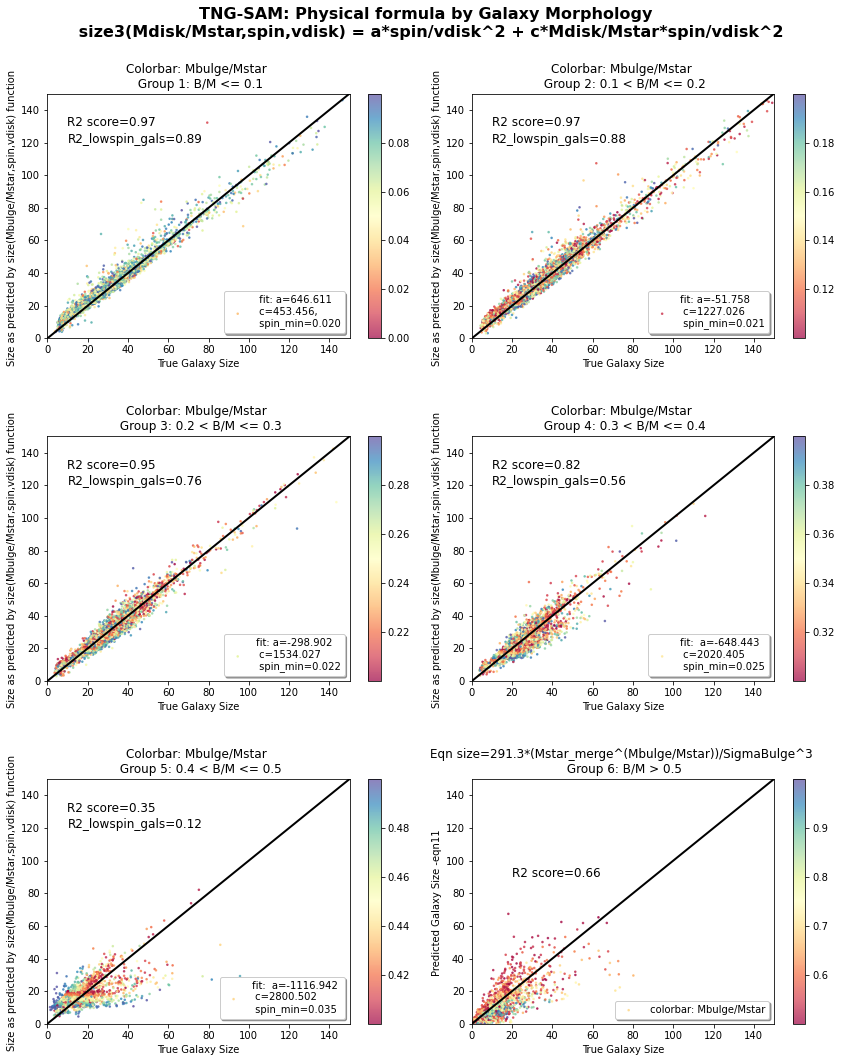

In [27]:
import matplotlib.cm as cm
import matplotlib.colors as norm
# from OpenCV import cv2 as cv #package OpenCV not installed

fig_all,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(12,15))
fig_all.suptitle('TNG-SAM: Physical formula by Galaxy Morphology \n size3(Mdisk/Mstar,spin,vdisk) = a*spin/vdisk^2 + c*Mdisk/Mstar*spin/vdisk^2', fontsize=16, fontweight='bold')


fig_1 = ax1.scatter(df_1.loc[:, 'GalpropNormHalfRadius'], results_df_1[3],
            c = df_1.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label=' fit: a=%5.3f \n c=%5.3f, \n spin_min=%5.3f' % tuple(popt1)) #,label= label, vmin=-2, vmax=1.0)
ax1.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_1[5]), size=12)
ax1.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_1[6]), size=12)
ax1.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax1.set_xlim([0.0,150])
ax1.set_ylim([0.0,150])
ax1.set_title('Colorbar: Mbulge/Mstar \n Group 1: B/M <= 0.1')
ax1.set_xlabel('True Galaxy Size')
ax1.legend(loc = 'lower right', shadow=True)
ax1.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_1, ax=ax1)

fig_2 = ax2.scatter(df_2.loc[:, 'GalpropNormHalfRadius'], results_df_2[3],
            c = df_2.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit: a=%5.3f \n c=%5.3f \n spin_min=%5.3f' % tuple(popt2)) #,label= label, vmin=-2, vmax=1.0)
ax2.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_2[5]), size=12)
ax2.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_2[6]), size=12)
ax2.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax2.set_xlim([0.0,150])
ax2.set_ylim([0.0,150])
ax2.set_title('Colorbar: Mbulge/Mstar \n Group 2: 0.1 < B/M <= 0.2')
ax2.set_xlabel('True Galaxy Size')
ax2.legend(loc = 'lower right', shadow=True)
ax2.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_2, ax=ax2)

fig_3 = ax3.scatter(df_3.loc[:, 'GalpropNormHalfRadius'], results_df_3[3],
            c = df_3.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit: a=%5.3f \n c=%5.3f \n spin_min=%5.3f' % tuple(popt3)) #,label= label, vmin=-2, vmax=1.0)
ax3.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_3[5]), size=12)
ax3.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_3[6]), size=12)
ax3.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax3.set_xlim([0.0,150])
ax3.set_ylim([0.0,150])
ax3.set_title('Colorbar: Mbulge/Mstar \n Group 3: 0.2 < B/M <= 0.3')
ax3.set_xlabel('True Galaxy Size')
ax3.legend(loc = 'lower right', shadow=True)
ax3.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_3, ax=ax3)

fig_4 = ax4.scatter(df_4.loc[:, 'GalpropNormHalfRadius'], results_df_4[3],
            c = df_4.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit:  a=%5.3f \n c=%5.3f \n spin_min=%5.3f' % tuple(popt4)) #,label= label, vmin=-2, vmax=1.0)
ax4.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_4[5]), size=12)
ax4.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_4[6]), size=12)
ax4.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax4.set_xlim([0.0,150])
ax4.set_ylim([0.0,150])
ax4.set_title('Colorbar: Mbulge/Mstar \n Group 4: 0.3 < B/M <= 0.4')
ax4.set_xlabel('True Galaxy Size')
ax4.legend(loc = 'lower right', shadow=True)
ax4.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_4, ax=ax4)

fig_5 = ax5.scatter(df_5.loc[:, 'GalpropNormHalfRadius'], results_df_5[3],
            c = df_5.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit:  a=%5.3f \n c=%5.3f \n spin_min=%5.3f' % tuple(popt5)) #,label= label, vmin=-2, vmax=1.0)
ax5.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_5[5]), size=12)
ax5.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_5[6]), size=12)
ax5.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax5.set_xlim([0.0,150])
ax5.set_ylim([0.0,150])
ax5.set_title('Colorbar: Mbulge/Mstar \n Group 5: 0.4 < B/M <= 0.5')
ax5.set_xlabel('True Galaxy Size')
ax5.legend(loc = 'lower right', shadow=True)
ax5.set_ylabel('Size as predicted by size(Mbulge/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_5, ax=ax5)


fig_6 = ax6.scatter(df_6.loc[:, 'GalpropNormHalfRadius'], eqn11,
            c = df_6.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label=' colorbar: Mbulge/Mstar') #,label= label, vmin=-2, vmax=1.0)
ax6.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_11), size=12)
ax6.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax6.set_xlim([0.0,150])
ax6.set_ylim([0.0,150])
ax6.set_title('Eqn size=291.3*(Mstar_merge^(Mbulge/Mstar))/SigmaBulge^3 \n Group 6: B/M > 0.5')
ax6.set_xlabel('True Galaxy Size')
ax6.legend(loc = 'lower right', shadow=True)
ax6.set_ylabel('Predicted Galaxy Size -eqn11 ')
fig_all.colorbar(fig_6, ax=ax6)

# def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
#     "Sign sets of subplots with title"
#     row = fig.add_subplot(grid)
#     # the '\n' is important
#     row.set_title(f'{title}\n', fontweight='semibold')
#     # hide subplot
#     row.set_frame_on(False)
#     row.axis('off')
    
# grid2 = plt.GridSpec(2, 2)
# create_subtitle(fig2, grid2[0, ::], 'mHI')
# create_subtitle(fig2, grid2[1, ::], 'mH2')
fig_all.tight_layout()
fig_all.subplots_adjust(top=0.90, hspace=0.4) #, wspace=0.4)

# plt.savefig("TNG-SAM_physformula_size3_diskmstar_spinvdisk2_by_Galaxy_Morphology.jpeg", dpi=500)
plt.show()

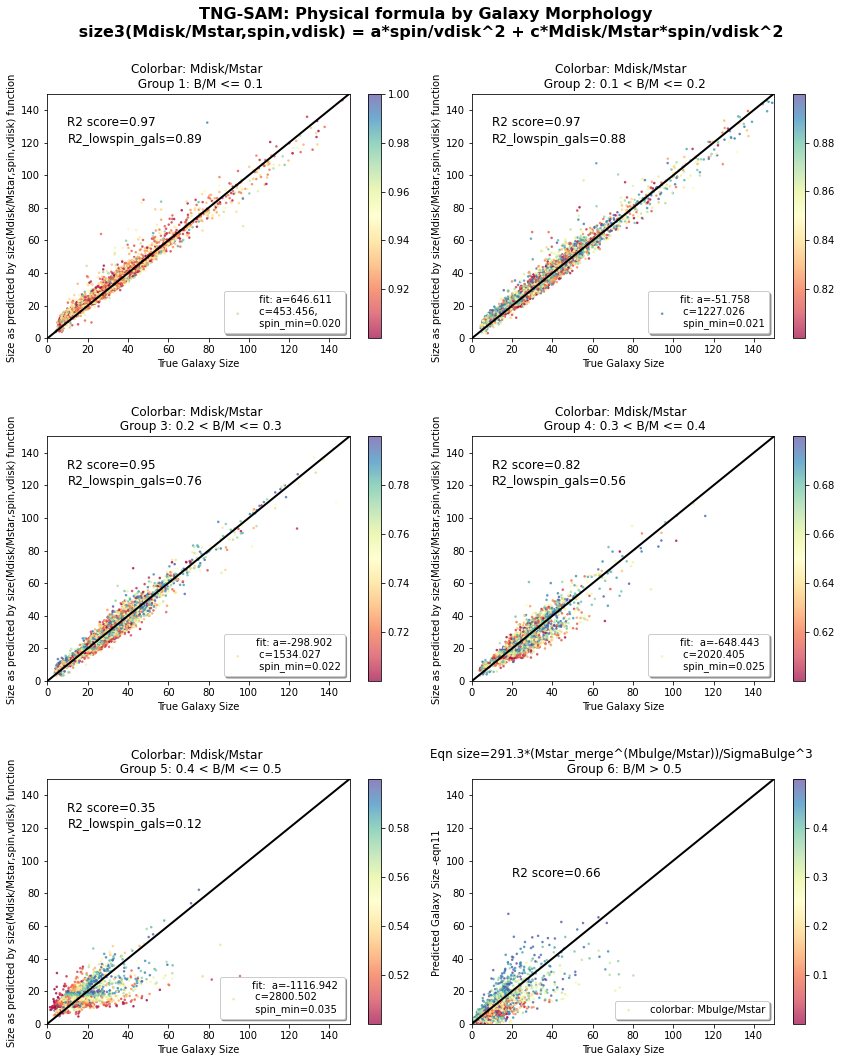

In [28]:
import matplotlib.cm as cm
import matplotlib.colors as norm
# from OpenCV import cv2 as cv #package OpenCV not installed

fig_all,[(ax1, ax2), (ax3, ax4), (ax5, ax6)]=plt.subplots(nrows=3,ncols=2,figsize=(12,15))
fig_all.suptitle('TNG-SAM: Physical formula by Galaxy Morphology \n size3(Mdisk/Mstar,spin,vdisk) = a*spin/vdisk^2 + c*Mdisk/Mstar*spin/vdisk^2', fontsize=16, fontweight='bold')


fig_1 = ax1.scatter(df_1.loc[:, 'GalpropNormHalfRadius'], results_df_1[3],
            c = df_1.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label=' fit: a=%5.3f \n c=%5.3f, \n spin_min=%5.3f' % tuple(popt1)) #,label= label, vmin=-2, vmax=1.0)
ax1.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_1[5]), size=12)
ax1.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_1[6]), size=12)
ax1.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax1.set_xlim([0.0,150])
ax1.set_ylim([0.0,150])
ax1.set_title('Colorbar: Mdisk/Mstar \n Group 1: B/M <= 0.1')
ax1.set_xlabel('True Galaxy Size')
ax1.legend(loc = 'lower right', shadow=True)
ax1.set_ylabel('Size as predicted by size(Mdisk/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_1, ax=ax1)

fig_2 = ax2.scatter(df_2.loc[:, 'GalpropNormHalfRadius'], results_df_2[3],
            c = df_2.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit: a=%5.3f \n c=%5.3f \n spin_min=%5.3f' % tuple(popt2)) #,label= label, vmin=-2, vmax=1.0)
ax2.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_2[5]), size=12)
ax2.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_2[6]), size=12)
ax2.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax2.set_xlim([0.0,150])
ax2.set_ylim([0.0,150])
ax2.set_title('Colorbar: Mdisk/Mstar \n Group 2: 0.1 < B/M <= 0.2')
ax2.set_xlabel('True Galaxy Size')
ax2.legend(loc = 'lower right', shadow=True)
ax2.set_ylabel('Size as predicted by size(Mdisk/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_2, ax=ax2)

fig_3 = ax3.scatter(df_3.loc[:, 'GalpropNormHalfRadius'], results_df_3[3],
            c = df_3.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit: a=%5.3f \n c=%5.3f \n spin_min=%5.3f' % tuple(popt3)) #,label= label, vmin=-2, vmax=1.0)
ax3.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_3[5]), size=12)
ax3.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_3[6]), size=12)
ax3.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax3.set_xlim([0.0,150])
ax3.set_ylim([0.0,150])
ax3.set_title('Colorbar: Mdisk/Mstar \n Group 3: 0.2 < B/M <= 0.3')
ax3.set_xlabel('True Galaxy Size')
ax3.legend(loc = 'lower right', shadow=True)
ax3.set_ylabel('Size as predicted by size(Mdisk/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_3, ax=ax3)

fig_4 = ax4.scatter(df_4.loc[:, 'GalpropNormHalfRadius'], results_df_4[3],
            c = df_4.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit:  a=%5.3f \n c=%5.3f \n spin_min=%5.3f' % tuple(popt4)) #,label= label, vmin=-2, vmax=1.0)
ax4.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_4[5]), size=12)
ax4.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_4[6]), size=12)
ax4.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax4.set_xlim([0.0,150])
ax4.set_ylim([0.0,150])
ax4.set_title('Colorbar: Mdisk/Mstar \n Group 4: 0.3 < B/M <= 0.4')
ax4.set_xlabel('True Galaxy Size')
ax4.legend(loc = 'lower right', shadow=True)
ax4.set_ylabel('Size as predicted by size(Mdisk/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_4, ax=ax4)

fig_5 = ax5.scatter(df_5.loc[:, 'GalpropNormHalfRadius'], results_df_5[3],
            c = df_5.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label='fit:  a=%5.3f \n c=%5.3f \n spin_min=%5.3f' % tuple(popt5)) #,label= label, vmin=-2, vmax=1.0)
ax5.text(10, 130, 'R2 score=' + '{:.2f}'.format(results_df_5[5]), size=12)
ax5.text(10, 120, 'R2_lowspin_gals=' + '{:.2f}'.format(results_df_5[6]), size=12)
ax5.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax5.set_xlim([0.0,150])
ax5.set_ylim([0.0,150])
ax5.set_title('Colorbar: Mdisk/Mstar \n Group 5: 0.4 < B/M <= 0.5')
ax5.set_xlabel('True Galaxy Size')
ax5.legend(loc = 'lower right', shadow=True)
ax5.set_ylabel('Size as predicted by size(Mdisk/Mstar,spin,vdisk) function ')
fig_all.colorbar(fig_5, ax=ax5)


fig_6 = ax6.scatter(df_6.loc[:, 'GalpropNormHalfRadius'], eqn11,
            c = df_6.loc[:,'DiskMstar_ratio'],  cmap='Spectral',
            s=10, marker='.', alpha=0.7, label=' colorbar: Mbulge/Mstar') #,label= label, vmin=-2, vmax=1.0)
ax6.text(20, 90, 'R2 score=' + '{:.2f}'.format(r2_score_11), size=12)
ax6.plot([0.0, 150], [0.0, 150], color = 'black', linewidth = 2)
ax6.set_xlim([0.0,150])
ax6.set_ylim([0.0,150])
ax6.set_title('Eqn size=291.3*(Mstar_merge^(Mbulge/Mstar))/SigmaBulge^3 \n Group 6: B/M > 0.5')
ax6.set_xlabel('True Galaxy Size')
ax6.legend(loc = 'lower right', shadow=True)
ax6.set_ylabel('Predicted Galaxy Size -eqn11 ')
fig_all.colorbar(fig_6, ax=ax6)

# def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
#     "Sign sets of subplots with title"
#     row = fig.add_subplot(grid)
#     # the '\n' is important
#     row.set_title(f'{title}\n', fontweight='semibold')
#     # hide subplot
#     row.set_frame_on(False)
#     row.axis('off')
    
# grid2 = plt.GridSpec(2, 2)
# create_subtitle(fig2, grid2[0, ::], 'mHI')
# create_subtitle(fig2, grid2[1, ::], 'mH2')
fig_all.tight_layout()
fig_all.subplots_adjust(top=0.90, hspace=0.4) #, wspace=0.4)

# plt.savefig("TNG-SAM_physformula_size3_diskmstar_spinvdisk2_by_Galaxy_Morphology_mdiskratiocolorbar.jpeg", dpi=500)
plt.show()

### popt trend over galaxy morphology bins for size1

In [18]:
mean_BulgeMstar_per_bin = [np.mean(df_1.loc[:, 'BulgeMstar_ratio']),
                                   np.mean(df_2.loc[:, 'BulgeMstar_ratio']),
                                   np.mean(df_3.loc[:, 'BulgeMstar_ratio']),
                                   np.mean(df_4.loc[:, 'BulgeMstar_ratio']),
                                   np.mean(df_5.loc[:, 'BulgeMstar_ratio'])
                          ]

mean_BulgeMstar_per_bin = np.array(mean_BulgeMstar_per_bin)

In [19]:
mean_DiskMstar_per_bin = [np.mean(df_1.loc[:, 'DiskMstar_ratio']),
                                   np.mean(df_2.loc[:, 'DiskMstar_ratio']),
                                   np.mean(df_3.loc[:, 'DiskMstar_ratio']),
                                   np.mean(df_4.loc[:, 'DiskMstar_ratio']),
                                   np.mean(df_5.loc[:, 'DiskMstar_ratio'])
                          ]

mean_DiskMstar_per_bin = np.array(mean_DiskMstar_per_bin)

### popt trend over galaxy morphology bins for size2

In [20]:
# popt = [a, c, spin_min]
popt1

array([6.46611394e+02, 4.53456148e+02, 2.00800195e-02])

In [21]:
a_values_per_bin = [popt1[0], popt2[0], popt3[0], popt4[0], popt5[0]]

a_values_per_bin = np.array(a_values_per_bin)

c_values_per_bin = [popt1[1], popt2[1], popt3[1], popt4[1], popt5[1]]

c_values_per_bin = np.array(c_values_per_bin)


In [22]:
# spin_min_values_per_bin = [0.021, 0.021, 0.021, 0.021, 0.021]

spin_min_values_per_bin = [popt1[2], popt2[2], popt3[2], popt4[2], popt5[2]]

spin_min_values_per_bin = np.array (spin_min_values_per_bin)

spin_min_values_per_bin

array([0.02008002, 0.02054891, 0.02184723, 0.02450667, 0.03519946])

In [23]:
a_values_per_bin

array([  646.61139405,   -51.75751084,  -298.90193519,  -648.44318207,
       -1116.94169406])

In [24]:
a_values_per_bin[0:4]

array([ 646.61139405,  -51.75751084, -298.90193519, -648.44318207])

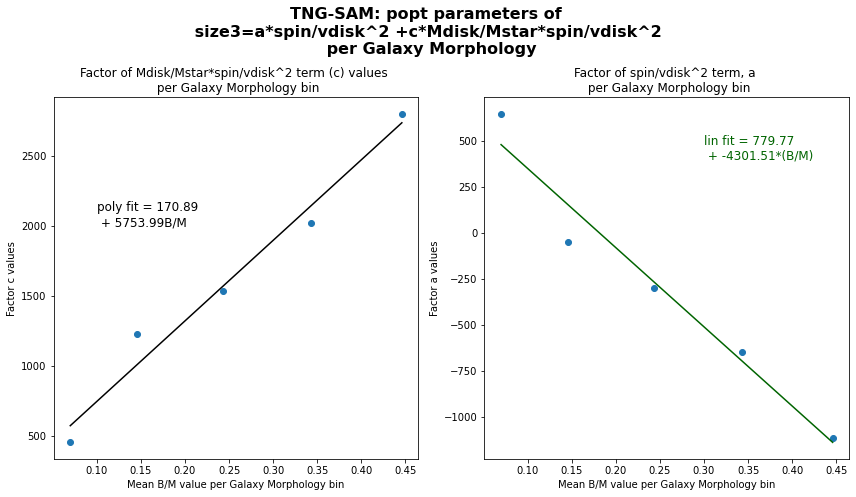

In [25]:
fig,[ax1,ax2]=plt.subplots(nrows=1,ncols=2,figsize=(12,7))
fig.suptitle('TNG-SAM: popt parameters of \n size3=a*spin/vdisk^2 +c*Mdisk/Mstar*spin/vdisk^2 \n per Galaxy Morphology', fontsize=16, fontweight='bold')

b1_poly, a1_poly = np.polyfit(mean_BulgeMstar_per_bin, c_values_per_bin , 1)

ax1.scatter(mean_BulgeMstar_per_bin, c_values_per_bin)
ax1.set_title('Factor of Mdisk/Mstar*spin/vdisk^2 term (c) values \n per Galaxy Morphology bin')
ax1.set_xlabel('Mean B/M value per Galaxy Morphology bin')
ax1.set_ylabel('Factor c values')
#add line of best fit to plot
ax1.plot(mean_BulgeMstar_per_bin, b1_poly*mean_BulgeMstar_per_bin+a1_poly, color='black') 
#add fitted regression equation to plot
ax1.text(0.1, 2000, 'poly fit = ' + '{:.2f}'.format(a1_poly) + '\n + {:.2f}'.format(b1_poly) + 'B/M', size=12)
#ax1.legend(loc='upper right')


b3_poly_1, a3_poly_1 = np.polyfit(mean_BulgeMstar_per_bin, a_values_per_bin , 1)
# c3_poly, b3_poly, a3_poly = np.polyfit(mean_BulgeMstar_per_bin, a_values_per_bin , 2)


ax2.scatter(mean_BulgeMstar_per_bin, a_values_per_bin)
ax2.set_title('Factor of spin/vdisk^2 term, a \n per Galaxy Morphology bin')
ax2.set_xlabel('Mean B/M value per Galaxy Morphology bin')
ax2.set_ylabel('Factor a values')
#add line of best fit to plot
# ax2.plot(mean_BulgeMstar_per_bin,c3_poly*mean_BulgeMstar_per_bin**2 + b3_poly*mean_BulgeMstar_per_bin+a3_poly, color='black') 
ax2.plot(mean_BulgeMstar_per_bin,b3_poly_1*mean_BulgeMstar_per_bin+a3_poly_1, color='darkgreen') 

#add fitted regression equation to plot
ax2.text(0.3, 400, 'lin fit = ' + '{:.2f}'.format(a3_poly_1) + '\n + {:.2f}'.format(b3_poly_1) + '*(B/M)', size=12, color='darkgreen')
# ax2.text(0.3, 500, 'sq fit = ' + '{:.2f}'.format(a3_poly) + '\n + {:.2f}'.format(b3_poly) + 'B/M'  + '\n + {:.2f}'.format(c3_poly) + 'B/M^2', size=12)


fig.tight_layout()
fig.subplots_adjust(top=0.8)
# plt.savefig("TNG-SAM_popt_size3_per_Galaxy_Morphology.jpeg", dpi=500)
plt.show()